In [2]:
import copy
import numpy as np
import random
from math import pi
from torch import optim
import sys

sys.path.append('../../')
from utils.modules import *
from torch.distributions import Uniform

from torchdyn.core import ODEProblem
from torchdyn.numerics import DormandPrince45

In [4]:
# seeding experiment
seed = 123
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Models

In [5]:
class NHARobotControlLearner(nn.Module):
    """Dynamics of the controlled differential-drive mobile robot"""

    def __init__(self, number_of_resources, hdim=256):
        super().__init__()

        self.control = nn.Sequential(
            nn.Linear(5, hdim),  # dxdt, dydt, dthetadt, x_target, y_target
            nn.SiLU(),
            nn.Linear(hdim, hdim),
            nn.SiLU(),
            nn.Linear(hdim, hdim),
            nn.SiLU(),
            nn.Linear(hdim, hdim),
            nn.Tanh(),
            nn.Linear(hdim, 2))

    # closed-loop system dynamics
    def forward(self, t, z):

        # evaluate controller
        u = self.control(z.float())

        # evaluate state derivatives
        dxdt = torch.cos(z[:, -1:]) * u[:, :1]
        dydt = torch.sin(z[:, -1:]) * u[:, :1]
        dthetadt = u[:, 1:]

        self.dzdt = torch.cat([dxdt, dydt, dthetadt, z[:, -2:]], 1)

        return self.dzdt 

## Train

In [6]:
def simulation_step(x0, action_indeces, resource_map, ode_opt):

    rx = torch.gather(resource_map[..., 0], 1, action_indeces.to(DEVICE)[:, None])
    ry = torch.gather(resource_map[..., 1], 1, action_indeces.to(DEVICE)[:, None])
    targets = torch.cat((rx, ry), dim=-1)
    target_indices = torch.argmin(torch.pow(x0[:, :2].unsqueeze(1).repeat(1, 5, 1) - resource_map, 2).sum(-1), dim=-1)

    z0 = torch.cat([x0, targets], -1)

    # Forward pass through ODE
    t_eval, sol = prob.forward(z0, )

    # backward
    loss = nn.MSELoss()(sol[-1, :, :2], targets)
    loss.backward()
    ode_opt.step()
    ode_opt.zero_grad()

    # compute rewards
    rewards = (action_indeces==target_indices).float()/1000 
    return rewards, loss

In [7]:
def reinforce(policy_estimator, resource_locations, num_episodes=2000):
    # Set up lists to hold results
    total_rewards = []

    # Define optimizer
    rl_opt = optim.Adam(policy_estimator.network.parameters(), lr=1e-2)

    ep = 0
    all_rewards = []
    all_ode_losses = []
    while ep < num_episodes:

        ode_losses = []
        sim_rewards = []
        for simulated_map in resource_locations:

            # reset simulation state (randomly initialize robot positions)
            x0 = x0_dist.sample((BATCH_SIZE,)).to(DEVICE)

            # ----- COMPUTE LOSS FOR ODE AND BACKPROP -----
            s_0 = torch.cat((x0, simulated_map.view(-1, 2*number_of_resources)), dim=1)

            # Get actions -> actions = target indeces
            action_probs = policy_estimator.predict(s_0)
            action_dist = Categorical(action_probs)
            sample = action_dist.sample((1,)).view(-1)

            r, odeloss = simulation_step(x0, sample, simulated_map, ode_opt)

            total_rewards.append(r.sum().detach().cpu().item())

            # ----- COMPUTE LOSS FOR RL AND BACKPROP -----
            rl_opt.zero_grad()
            reward_tensor = r
            action_tensor = sample

            # Calculate loss for rl
            logprob = torch.log(action_probs)

            selected_logprobs = reward_tensor.to(DEVICE).view(-1, 1) * torch.gather(logprob, 1, action_tensor.view(-1, 1))
            loss = -selected_logprobs.mean()

            # Calculate & Apply gradients for rl
            loss.backward()
            rl_opt.step()

            avg_batch_rewards = np.mean(total_rewards[-100:])

            ode_losses.append(odeloss.cpu().item())
            sim_rewards.append(avg_batch_rewards)

        ep += 1

        avg_ode = np.average(ode_losses)
        avg_rewards = np.average(sim_rewards)
        all_rewards.append(sim_rewards)
        all_ode_losses.append(ode_losses)

        # Print running average
        print(f'Ep: {ep + 1}, Average reward of last 100: {avg_rewards:.2f}, ODE loss: {avg_ode:.3f}', flush=True, end="\r")

        # stop if performance is enough
        if avg_ode <= 0.005 and avg_rewards > 79.5:
            break

    return all_ode_losses, all_rewards

In [20]:
# if you don't have enough memory available reduce the batch size
BATCH_SIZE = 10000


number_of_resources = 5

# create a distribution for the robot swarm
x0_dist = Uniform(torch.tensor([-2.5, -1., 0.]), torch.tensor([2.5, 1., 2. * pi]))

# set 2 map layouts positions
resources = [torch.tensor([[-1., 2.], [-0.5, 2.], [0., 2.], [0.5, 2.], [1., 2.]]).to(DEVICE),
             torch.tensor([[-2., 2.], [-1., 2.], [0., 2.], [1., 2.], [2., 2.]]).to(DEVICE)]  
resource_locations = [resource.repeat(BATCH_SIZE, 1, 1).to(DEVICE) for resource in resources]

# Initialize Neural ODE
model = RobotControlLearner(number_of_resources, hdim=64).to(DEVICE)


solver = DormandPrince45()
t_span = torch.tensor([0., 5]).to(DEVICE)

solver.sync_device_dtype(t_span, t_span)
prob = ODEProblem(model, solver=solver, atol=1e-3, rtol=1e-3)
ode_opt = torch.optim.Adadelta(list(mo.parameters()), lr=3e-3)


# Initialize REINFORCE target selector --- input: map & robot position, output: map target selector
policy_est = policy_estimator(3 + 2*number_of_resources, number_of_resources)

In [ ]:
# train 
all_ode_losses, all_rewards = reinforce(policy_est, resource_locations, num_episodes=5000)

### Plot - Evaluate

In [8]:
def plot_swarm_map(policy_est, prob, x0_dist, resources, repeat_no, number_of_robots, dynamics=False):

    fig = plt.figure(figsize=(18, 4))

    number_of_resources = resources[0].shape[0]
    test_resource_locations = [resource.repeat(number_of_robots, 1, 1).to(DEVICE) for resource in resources]
    sol = None
    sol_ = None

    accs = []
    dists = []

    for i in range(0, repeat_no):

        if sol_ is not None:
            x0 = sol_[-1, ..., :3].detach().to(DEVICE)
            x0[..., 1:2] = x0[..., 1:2] - i
        else:
            x0 = x0_dist.sample((number_of_robots,)).to(DEVICE)

        # Choose next map  based on the predefined sequence
        idx = i % len(resources)
        target_locations_tmp = test_resource_locations[idx]

        # get the RL module to estimate the targets
        s_0 = torch.cat((x0, target_locations_tmp.view(-1, 2 * number_of_resources)), dim=1)
        action_probs = policy_est.predict(s_0)
        target_indices = torch.argmax(action_probs, dim=1)


        # get the ode to perform a step of the simulation
        rx = torch.gather(target_locations_tmp[..., 0], 1, target_indices.to(DEVICE)[:, None])
        ry = torch.gather(target_locations_tmp[..., 1], 1, target_indices.to(DEVICE)[:, None])
        targets = torch.cat((rx, ry), dim=-1)
        z0 = torch.cat([x0, targets], -1)

        if dynamics:
            z0 = torch.cat([torch.zeros(z0.shape[0], 1, dtype=z0.dtype, device=z0.device), z0], -1).float()

        t_eval, sol = prob.forward(z0, torch.tensor([0., 5]))


        sol_ = sol[..., 1:]

        rmse = nn.MSELoss()(sol_[-1, :, 1:2], targets)
        sol_[..., 1:2] = sol_[..., 1:2] + i

        # ----- UPDATE PLOTS ------
        sol_plt = sol_.detach().cpu()
        targets_plt = target_locations_tmp.cpu()
        plt.plot(sol_plt[:, :number_of_robots, 1], sol_plt[:, :number_of_robots, 0], c='red', alpha=0.2, linestyle='--')
        plt.scatter(sol_plt[0, :number_of_robots, 1], sol_plt[0, :number_of_robots, 0], c='black', s=8)
        plt.scatter(sol_plt[-1, :number_of_robots, 1], sol_plt[-1, :number_of_robots, 0], c='black', s=8)
        plt.scatter(targets_plt[0, :, 1].cpu() + i, targets_plt[0, :, 0].cpu(), c='blue', s=170)
        plt.ylim(-3., 3.)
        plt.xlim(-1.5, 11.5)

        # compute errors and accs
        true_targets = torch.argmin(torch.pow(x0[:, :2].unsqueeze(1).repeat(1, 5, 1) - target_locations_tmp, 2).sum(-1),
                                      dim=-1)
        accs.append(torch.sum((true_targets == target_indices).float()) / target_indices.shape[0])
        dists.append(rmse)

    print("Average model batch accuracy: {} +-{}\n"
          "Average control batch RMSE: {} +-{}\n"
          .format(torch.mean(torch.tensor(accs)), torch.sqrt(torch.std(torch.tensor(accs)))/len(accs),
                  torch.mean(torch.tensor(dists)), torch.sqrt(torch.std(torch.tensor(dists)))/len(accs)))
    plt.show()
    return fig


def plot_training_curves(ode_losses, rewards):
    fig = plt.figure(figsize=(10, 5))
    fig, ax1 = plt.subplots()

    ax = fig.add_subplot(111, frameon=False)
    ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

    colors = ["#4287f5", "#db3000", "#595959"]

    ax2 = ax1.twinx()

    no_of_episodes = len(ode_losses)

    np_ode_losses = np.average(np.array(ode_losses), axis=-1)
    np_rewards = np.average(np.array(rewards), axis=-1)

    if no_of_episodes > 1000:
        step_change = round(no_of_episodes / 100)  # let's make plots with 100 datapoints
    else:
        step_change = 1

    avg_rewards = []
    stds_rewards = []
    avg_losses = []
    stds_losses = []
    idxes = []
    for idx in range(0, no_of_episodes, step_change):
        avg_rewards.append(np.average(np_rewards[idx:idx + step_change]))
        stds_rewards.append(np.std(np_rewards[idx:idx + step_change]))
        avg_losses.append(np.average(np_ode_losses[idx:idx + step_change]))
        stds_losses.append(np.std(np_ode_losses[idx:idx + step_change]))
        idxes.append(idx + round(step_change / 2))

    avg_rewards = np.array(avg_rewards)
    stds_rewards = np.array(stds_rewards)
    avg_losses = np.array(avg_losses)
    stds_losses = np.array(stds_losses)

    pt2 = ax2.plot(idxes, avg_rewards, label="Average REINFORCE rewards", color=colors[0])
    ax2.fill_between(idxes, avg_rewards - 2 * stds_rewards, avg_rewards + 2 * stds_rewards, facecolor=colors[0],
                     alpha=0.6)
    ax2.set_ylabel('Rewards', fontsize=13)

    pt1 = ax1.plot(idxes, avg_losses, label="Average Control Loss", color=colors[1])
    ax1.fill_between(idxes, avg_losses - 2 * stds_losses, avg_losses + 2 * stds_losses,
                     facecolor=colors[1], alpha=0.6)
    ax1.set_ylabel('loss', fontsize=13)

    labels = [l.get_label() for l in pt1 + pt2]
    ax.legend(pt1 + pt2, labels, loc='center right', fontsize=11)

    plt.xlabel('Episodes')  # we already handled the x-label with ax1

    fig.tight_layout()

    return fig

<Figure size 720x360 with 0 Axes>

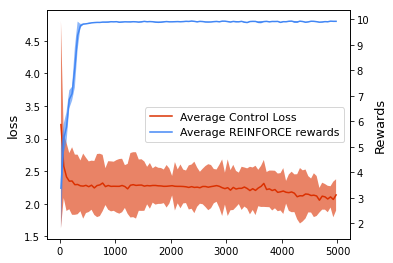

In [9]:
plot_training_curves(all_ode_losses, all_rewards);